# Capstone 2 Los Angeles Metro Bikes

## Feature Engineering and Model Selection 

In [748]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.distance import geodesic 
from sklearn.neighbors import BallTree
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from datetime import datetime
import calendar

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam




pd.options.display.max_columns = 400
pd.options.display.max_rows = 400
%matplotlib inline

stations = pd.read_csv('/Users/oliverbohler/Desktop/Springboard/RideShare/Code/rideshare_cleaned.csv')


In [750]:
stations.head()

,trip_id,year,month,day,day_name,start_date,end_date,start_time_new,end_time_new,duration,trip_route_category,passholder_type,bike_id,bike_type,start_station,start_station_name,start_station_region,start_lat,start_lon,end_station,end_station_name,end_station_region,end_lat,end_lon,num_of_docks
0,197703662,2022,7,1,Friday,2022-07-01,2022-07-01,00:02:00,00:04:00,2,One Way,Monthly Pass,24302,electric,4406,Normandie & Hollywood,DTLA,34.101891,-118.300613,4442,Normandie & Sunset,DTLA,34.098000,-118.300468,14.0
1,197704062,2022,7,1,Friday,2022-07-01,2022-07-01,00:19:00,00:22:00,3,Round Trip,Walk-up,19941,electric,3082,Traction & Rose,DTLA,34.046520,-118.237411,3082,Traction & Rose,DTLA,34.046520,-118.237411,27.0
2,197704162,2022,7,1,Friday,2022-07-01,2022-07-01,00:23:00,00:25:00,2,Round Trip,Walk-up,17445,electric,3082,Traction & Rose,DTLA,34.046520,-118.237411,3082,Traction & Rose,DTLA,34.046520,-118.237411,27.0
3,197708062,2022,7,1,Friday,2022-07-01,2022-07-01,00:26:00,01:05:00,39,One Way,Walk-up,19941,electric,3082,Traction & Rose,DTLA,34.046520,-118.237411,3063,Pershing Square,DTLA,34.048038,-118.253738,27.0
4,197708364,2022,7,1,Friday,2022-07-01,2022-07-01,00:57:00,01:17:00,20,One Way,Annual Pass,13957,standard,4566,Venice & Hughes,Westside,34.023392,-118.399223,4562,Sepulveda & National,Westside,34.026970,-118.428207,15.0


In [752]:
westside = stations[(stations['start_station_region'] == 'Westside') | (stations['end_station_region'] == 'Westside')]

In [754]:
westside['start_datetime'] = pd.to_datetime(
    westside['start_date'].astype(str) + ' ' + westside['start_time_new'].astype(str)
)

westside['end_datetime'] = pd.to_datetime(
    westside['end_date'].astype(str) + ' ' + westside['end_time_new'].astype(str)
)

westside.head()

/var/folders/0z/41_yxdy57v5gqbv0vhg6ky780000gn/T/ipykernel_1456/317169341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  westside['start_datetime'] = pd.to_datetime(
/var/folders/0z/41_yxdy57v5gqbv0vhg6ky780000gn/T/ipykernel_1456/317169341.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  westside['end_datetime'] = pd.to_datetime(


,trip_id,year,month,day,day_name,start_date,end_date,start_time_new,end_time_new,duration,trip_route_category,passholder_type,bike_id,bike_type,start_station,start_station_name,start_station_region,start_lat,start_lon,end_station,end_station_name,end_station_region,end_lat,end_lon,num_of_docks,start_datetime,end_datetime
4,197708364,2022,7,1,Friday,2022-07-01,2022-07-01,00:57:00,01:17:00,20,One Way,Annual Pass,13957,standard,4566,Venice & Hughes,Westside,34.023392,-118.399223,4562,Sepulveda & National,Westside,34.026970,-118.428207,15.0,2022-07-01 00:57:00,2022-07-01 01:17:00
31,197731169,2022,7,1,Friday,2022-07-01,2022-07-01,06:37:00,06:56:00,19,One Way,Monthly Pass,16173,standard,4579,Alla & Glencoe,Westside,33.984859,-118.431129,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,12.0,2022-07-01 06:37:00,2022-07-01 06:56:00
34,197730862,2022,7,1,Friday,2022-07-01,2022-07-01,06:39:00,06:45:00,6,One Way,Monthly Pass,6330,standard,4515,Mississippi & Sawtelle,Westside,34.039742,-118.442268,4546,Expo/Bundy E Line Station,Westside,34.031399,-118.453629,9.0,2022-07-01 06:39:00,2022-07-01 06:45:00
35,197730963,2022,7,1,Friday,2022-07-01,2022-07-01,06:43:00,06:47:00,4,Round Trip,Walk-up,12017,standard,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,8.0,2022-07-01 06:43:00,2022-07-01 06:47:00
36,197734569,2022,7,1,Friday,2022-07-01,2022-07-01,06:48:00,07:07:00,19,Round Trip,Walk-up,15377,standard,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,8.0,2022-07-01 06:48:00,2022-07-01 07:07:00


In [756]:
westside['time'] = westside['start_datetime'].dt.round('h')
westside['time'] = pd.to_datetime(westside['time'], format = '%H:%M:%S' ).dt.time
westside.head()

/var/folders/0z/41_yxdy57v5gqbv0vhg6ky780000gn/T/ipykernel_1456/2296181828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  westside['time'] = westside['start_datetime'].dt.round('h')
/var/folders/0z/41_yxdy57v5gqbv0vhg6ky780000gn/T/ipykernel_1456/2296181828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  westside['time'] = pd.to_datetime(westside['time'], format = '%H:%M:%S' ).dt.time


,trip_id,year,month,day,day_name,start_date,end_date,start_time_new,end_time_new,duration,trip_route_category,passholder_type,bike_id,bike_type,start_station,start_station_name,start_station_region,start_lat,start_lon,end_station,end_station_name,end_station_region,end_lat,end_lon,num_of_docks,start_datetime,end_datetime,time
4,197708364,2022,7,1,Friday,2022-07-01,2022-07-01,00:57:00,01:17:00,20,One Way,Annual Pass,13957,standard,4566,Venice & Hughes,Westside,34.023392,-118.399223,4562,Sepulveda & National,Westside,34.026970,-118.428207,15.0,2022-07-01 00:57:00,2022-07-01 01:17:00,01:00:00
31,197731169,2022,7,1,Friday,2022-07-01,2022-07-01,06:37:00,06:56:00,19,One Way,Monthly Pass,16173,standard,4579,Alla & Glencoe,Westside,33.984859,-118.431129,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,12.0,2022-07-01 06:37:00,2022-07-01 06:56:00,07:00:00
34,197730862,2022,7,1,Friday,2022-07-01,2022-07-01,06:39:00,06:45:00,6,One Way,Monthly Pass,6330,standard,4515,Mississippi & Sawtelle,Westside,34.039742,-118.442268,4546,Expo/Bundy E Line Station,Westside,34.031399,-118.453629,9.0,2022-07-01 06:39:00,2022-07-01 06:45:00,07:00:00
35,197730963,2022,7,1,Friday,2022-07-01,2022-07-01,06:43:00,06:47:00,4,Round Trip,Walk-up,12017,standard,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,8.0,2022-07-01 06:43:00,2022-07-01 06:47:00,07:00:00
36,197734569,2022,7,1,Friday,2022-07-01,2022-07-01,06:48:00,07:07:00,19,Round Trip,Walk-up,15377,standard,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,8.0,2022-07-01 06:48:00,2022-07-01 07:07:00,07:00:00


In [758]:
westside['num_of_docks'] = westside['num_of_docks'].fillna(westside['num_of_docks'].mean())
westside['num_of_docks'] = westside['num_of_docks'].round().astype('int64')

/var/folders/0z/41_yxdy57v5gqbv0vhg6ky780000gn/T/ipykernel_1456/2268076895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  westside['num_of_docks'] = westside['num_of_docks'].fillna(westside['num_of_docks'].mean())
/var/folders/0z/41_yxdy57v5gqbv0vhg6ky780000gn/T/ipykernel_1456/2268076895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  westside['num_of_docks'] = westside['num_of_docks'].round().astype('int64')


In [760]:
westside['month_name'] = westside['month'].apply(lambda x: calendar.month_name[x])
print(westside[['month', 'month_name']].head())

    month month_name
4       7       July
31      7       July
34      7       July
35      7       July
36      7       July


/var/folders/0z/41_yxdy57v5gqbv0vhg6ky780000gn/T/ipykernel_1456/1018345882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  westside['month_name'] = westside['month'].apply(lambda x: calendar.month_name[x])


In [762]:
def get_season(month):
    """Returns the season name based on the month."""
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply function to create 'season' column
westside['season'] = westside['month'].apply(get_season)

# Display first few rows to check
print(westside[['month', 'season']].head())


    month  season
4       7  Summer
31      7  Summer
34      7  Summer
35      7  Summer
36      7  Summer


/var/folders/0z/41_yxdy57v5gqbv0vhg6ky780000gn/T/ipykernel_1456/1017172894.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  westside['season'] = westside['month'].apply(get_season)


In [764]:
westside.head()

,trip_id,year,month,day,day_name,start_date,end_date,start_time_new,end_time_new,duration,trip_route_category,passholder_type,bike_id,bike_type,start_station,start_station_name,start_station_region,start_lat,start_lon,end_station,end_station_name,end_station_region,end_lat,end_lon,num_of_docks,start_datetime,end_datetime,time,month_name,season
4,197708364,2022,7,1,Friday,2022-07-01,2022-07-01,00:57:00,01:17:00,20,One Way,Annual Pass,13957,standard,4566,Venice & Hughes,Westside,34.023392,-118.399223,4562,Sepulveda & National,Westside,34.026970,-118.428207,15,2022-07-01 00:57:00,2022-07-01 01:17:00,01:00:00,July,Summer
31,197731169,2022,7,1,Friday,2022-07-01,2022-07-01,06:37:00,06:56:00,19,One Way,Monthly Pass,16173,standard,4579,Alla & Glencoe,Westside,33.984859,-118.431129,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,12,2022-07-01 06:37:00,2022-07-01 06:56:00,07:00:00,July,Summer
34,197730862,2022,7,1,Friday,2022-07-01,2022-07-01,06:39:00,06:45:00,6,One Way,Monthly Pass,6330,standard,4515,Mississippi & Sawtelle,Westside,34.039742,-118.442268,4546,Expo/Bundy E Line Station,Westside,34.031399,-118.453629,9,2022-07-01 06:39:00,2022-07-01 06:45:00,07:00:00,July,Summer
35,197730963,2022,7,1,Friday,2022-07-01,2022-07-01,06:43:00,06:47:00,4,Round Trip,Walk-up,12017,standard,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,8,2022-07-01 06:43:00,2022-07-01 06:47:00,07:00:00,July,Summer
36,197734569,2022,7,1,Friday,2022-07-01,2022-07-01,06:48:00,07:07:00,19,Round Trip,Walk-up,15377,standard,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,8,2022-07-01 06:48:00,2022-07-01 07:07:00,07:00:00,July,Summer


In [766]:
columns_to_drop = ['month', 'day', 'start_date', 'end_date', 'start_time_new', 'end_time_new', ]
westside = westside.drop(columns = columns_to_drop)

In [768]:
westside.head()

,trip_id,year,day_name,duration,trip_route_category,passholder_type,bike_id,bike_type,start_station,start_station_name,start_station_region,start_lat,start_lon,end_station,end_station_name,end_station_region,end_lat,end_lon,num_of_docks,start_datetime,end_datetime,time,month_name,season
4,197708364,2022,Friday,20,One Way,Annual Pass,13957,standard,4566,Venice & Hughes,Westside,34.023392,-118.399223,4562,Sepulveda & National,Westside,34.026970,-118.428207,15,2022-07-01 00:57:00,2022-07-01 01:17:00,01:00:00,July,Summer
31,197731169,2022,Friday,19,One Way,Monthly Pass,16173,standard,4579,Alla & Glencoe,Westside,33.984859,-118.431129,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,12,2022-07-01 06:37:00,2022-07-01 06:56:00,07:00:00,July,Summer
34,197730862,2022,Friday,6,One Way,Monthly Pass,6330,standard,4515,Mississippi & Sawtelle,Westside,34.039742,-118.442268,4546,Expo/Bundy E Line Station,Westside,34.031399,-118.453629,9,2022-07-01 06:39:00,2022-07-01 06:45:00,07:00:00,July,Summer
35,197730963,2022,Friday,4,Round Trip,Walk-up,12017,standard,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,8,2022-07-01 06:43:00,2022-07-01 06:47:00,07:00:00,July,Summer
36,197734569,2022,Friday,19,Round Trip,Walk-up,15377,standard,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,4543,Toes Beach at Culver Blvd,Westside,33.957180,-118.451248,8,2022-07-01 06:48:00,2022-07-01 07:07:00,07:00:00,July,Summer


In [770]:
def hour_to_int(x):
    x = str(x)
    x=x[:2]
    x = int(x)
    return x

westside["time_int"] = westside['time']

In [772]:
westside['time_int'] = westside['time']
westside['time_int'] = westside['time_int'].astype('str')
westside['time_int'] = westside['time_int'].apply(lambda x: hour_to_int(x))

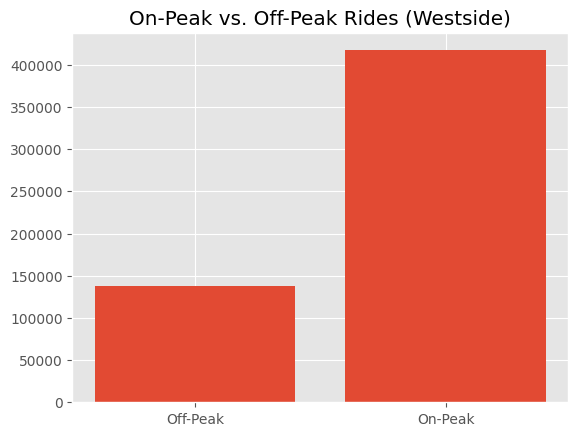

In [774]:
westside['peak'] = 0

westside.loc[(westside['time_int']>= 7.5 ) & (westside['time_int'] <= 18), 'peak'] = 1
westside.loc[(westside['day_name'].isin(['Saturday', 'Sunday'])) & ((westside['time_int'] <10.5) | (westside['time_int'] > 18)), 'peak'] = 0

plt.bar(westside['peak'].value_counts().index, westside['peak'].value_counts().values)
plt.xticks(ticks=[0, 1], labels=['Off-Peak', 'On-Peak'])
plt.title('On-Peak vs. Off-Peak Rides (Westside)')
plt.show()

In [775]:
trip_route_counts = westside.groupby(['passholder_type', 'trip_route_category']).size().reset_index(name='count')
print(trip_route_counts)


  passholder_type trip_route_category   count
0     Annual Pass             One Way   31378
1     Annual Pass          Round Trip    3634
2    Monthly Pass             One Way  194810
3    Monthly Pass          Round Trip   31619
4    One Day Pass             One Way   60252
5    One Day Pass          Round Trip   25327
6         Walk-up             One Way  128880
7         Walk-up          Round Trip   79101


In [778]:
length_of_trip = westside.groupby('passholder_type')['duration']
length_of_trip.describe()

,count,mean,std,min,25%,50%,75%,max
passholder_type,,,,,,,,
Annual Pass,35012.0,17.988632,44.103573,1.0,6.0,10.0,20.0,1440.0
Monthly Pass,226429.0,24.351289,50.674382,1.0,8.0,15.0,26.0,1440.0
One Day Pass,85579.0,77.926092,140.947895,1.0,20.0,38.0,84.0,1440.0
Walk-up,207981.0,66.157837,120.251489,1.0,23.0,40.0,71.0,1440.0


In [780]:
westside['passholder_type'].value_counts()

passholder_type
Monthly Pass    226429
Walk-up         207981
One Day Pass     85579
Annual Pass      35012
Name: count, dtype: int64

In [782]:
valid_passes= ['Monthly Pass', 'Walk-up']
westside = westside[westside['passholder_type'].isin(valid_passes)]

In [784]:
westside.columns

Index(['trip_id', 'year', 'day_name', 'duration', 'trip_route_category',
       'passholder_type', 'bike_id', 'bike_type', 'start_station',
       'start_station_name', 'start_station_region', 'start_lat', 'start_lon',
       'end_station', 'end_station_name', 'end_station_region', 'end_lat',
       'end_lon', 'num_of_docks', 'start_datetime', 'end_datetime', 'time',
       'month_name', 'season', 'time_int', 'peak'],
      dtype='object')

In [786]:
y = westside['passholder_type']
X = westside.drop(columns = ['trip_id', 'bike_id', 'bike_type', 'start_station', 'end_station', 'start_station_region', 
                             'end_station_region', 'start_datetime', 'end_datetime', 'time', 'passholder_type'])

In [788]:
X['start_station_name'] = X['start_station_name'].astype('str')
X['ending_station_name'] = X['end_station_name'].astype('str')

In [790]:
X = pd.get_dummies(X)

In [792]:
X.shape

(434410, 650)

In [794]:
scaler=StandardScaler()
scaler.fit_transform(X)

array([[-0.7775785 , -0.27199642, -0.66054551, ..., -0.01576943,
        -0.17750975, -0.00678539],
       [-0.7775785 , -0.41138902,  1.10520844, ..., -0.01576943,
        -0.17750975, -0.00678539],
       [-0.7775785 , -0.43283403, -1.55106358, ..., -0.01576943,
        -0.17750975, -0.00678539],
       ...,
       [-1.68670529,  3.53449364, -0.31626161, ..., -0.01576943,
        -0.17750975, -0.00678539],
       [-1.68670529, -0.18621636, -0.45779089, ..., -0.01576943,
        -0.17750975, -0.00678539],
       [-1.68670529,  3.59882868, -0.45779089, ..., -0.01576943,
        -0.17750975, -0.00678539]])

[99.37974346614153, 0.348491185513457, 0.19126807829712697, 0.013891261132683855, 0.004605056607716982]
99.99999999999977


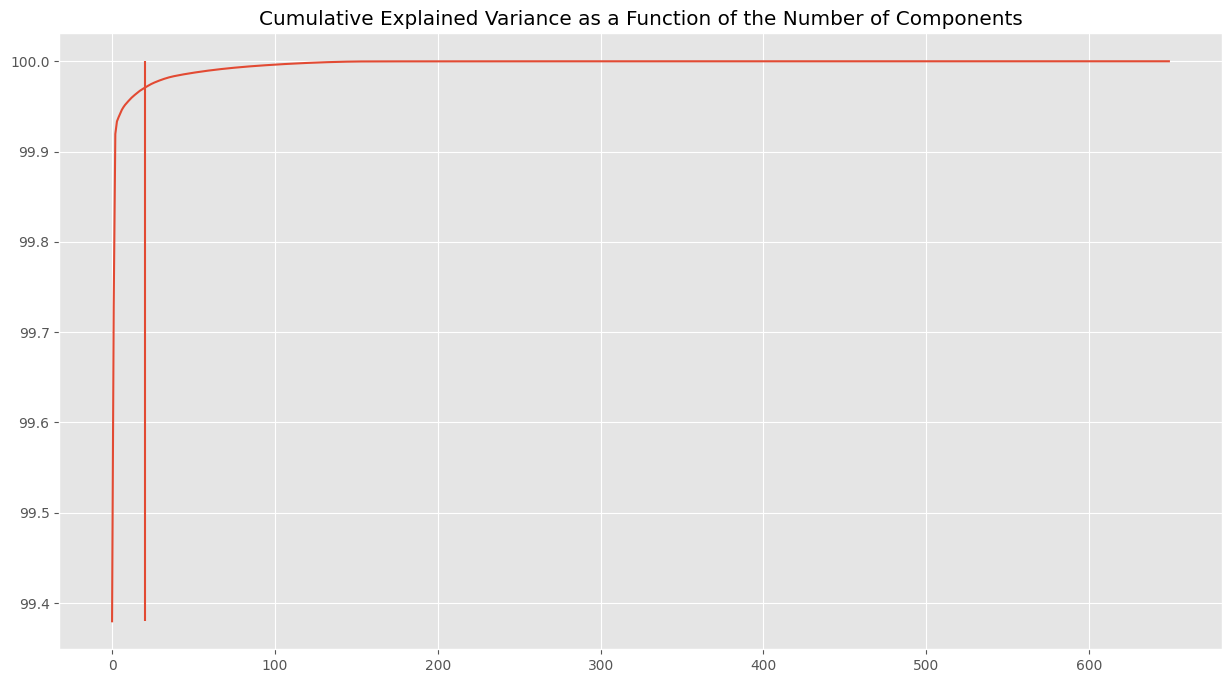

In [796]:
pca=PCA()
pca.fit(X)
tot = sum(pca.explained_variance_)
var_exp = [(i/tot)*100 for i in sorted(pca.explained_variance_, reverse=True)] 
print(var_exp[0:5])
print(sum(var_exp))
cum_var_exp = np.cumsum(var_exp) 
plt.style.use('ggplot')
plt.figure(figsize=(15, 8))
plt.plot(cum_var_exp)
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.vlines(x=20,ymin=var_exp[0],ymax=100)
plt.show()

In [798]:
pca = PCA(n_components = 10)
pca.fit(X)

PCA(n_components=10)

In [800]:
#Initial split (60% training, 40% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

#Split set into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 260646 samples
Validation set: 86882 samples
Test set: 86882 samples


In [802]:
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

In [804]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1) 

rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [806]:
y_val_pred = rf_model.predict(X_val)
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report (Validation Set):\n", classification_report(y_val, y_val_pred))

Validation Set Accuracy: 0.8187426624617297

Classification Report (Validation Set):
               precision    recall  f1-score   support

Monthly Pass       0.81      0.85      0.83     45444
     Walk-up       0.83      0.79      0.81     41438

    accuracy                           0.82     86882
   macro avg       0.82      0.82      0.82     86882
weighted avg       0.82      0.82      0.82     86882



In [808]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples for a split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'max_features': ['sqrt', 'log2', None]  # Feature selection per split
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

# Randomized Search
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Parameters:", best_params)

best_rf = random_search.best_estimator_
y_val_pred = best_rf.predict(X_val)

print("Optimized RF Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nOptimized Classification Report:\n", classification_report(y_val, y_val_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 5.3min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.0min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=15.3min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.5min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 5.3min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 3.0min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=15.3min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estima

In [838]:
y_test_pred = best_rf.predict(X_test)

print("Optimized RF Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nOptimized Classification Report:\n", classification_report(y_test, y_test_pred))

Optimized RF Accuracy: 0.8145070325268755

Optimized Classification Report:
               precision    recall  f1-score   support

Monthly Pass       0.81      0.84      0.83     45387
     Walk-up       0.82      0.78      0.80     41495

    accuracy                           0.81     86882
   macro avg       0.81      0.81      0.81     86882
weighted avg       0.81      0.81      0.81     86882



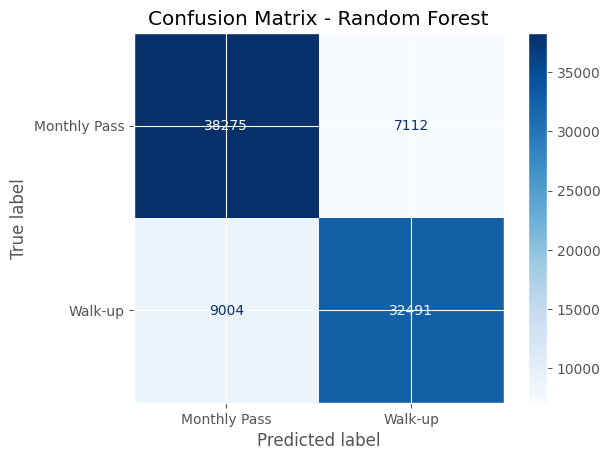

In [840]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Monthly Pass", "Walk-up"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [846]:
train_accuracy = accuracy_score(y_train, best_rf.predict(X_train))
val_accuracy = accuracy_score(y_val, best_rf.predict(X_val))
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.94
Validation Accuracy: 0.81
Test Accuracy: 0.81


## XGBoost

In [810]:
label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

# Check the mapping of labels to numbers
print("Class Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Class Mapping: {'Monthly Pass': 0, 'Walk-up': 1}


In [812]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [814]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Multi-class classification
    num_class=len(np.unique(y_train_enc)),  # Ensure correct number of classes
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_scaled, y_train_enc)

y_val_pred_enc = xgb_model.predict(X_val_scaled)
y_val_pred = label_encoder.inverse_transform(y_val_pred_enc)

print("XGBoost Validation Accuracy:", accuracy_score(y_val_enc, y_val_pred_enc))
print("\nXGBoost Classification Report:\n", classification_report(y_val_enc, y_val_pred_enc, target_names=label_encoder.classes_))

XGBoost Validation Accuracy: 0.7875164015561336

XGBoost Classification Report:
               precision    recall  f1-score   support

Monthly Pass       0.78      0.82      0.80     45444
     Walk-up       0.79      0.75      0.77     41438

    accuracy                           0.79     86882
   macro avg       0.79      0.79      0.79     86882
weighted avg       0.79      0.79      0.79     86882



In [818]:
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_search = RandomizedSearchCV(
    xgb.XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    verbose=2,
    n_jobs=-1
)

xgb_search.fit(X_train_scaled, y_train_enc)

print("Best Parameters:", xgb_search.best_params_)

# Use best model
best_xgb = xgb_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 700, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [821]:
xgb_optimized = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    n_estimators=700,
    max_depth=6,
    learning_rate=0.1,
    subsample= 0.7,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_optimized.fit(X_train_scaled, y_train_enc)

y_val_pred_enc = xgb_optimized.predict(X_val_scaled)
y_val_pred = label_encoder.inverse_transform(y_val_pred_enc)

print("XGBoost Validation Accuracy:", accuracy_score(y_val_enc, y_val_pred_enc))
print("\nXGBoost Classification Report:\n", classification_report(y_val_enc, y_val_pred_enc, target_names=label_encoder.classes_))

XGBoost Validation Accuracy: 0.7988651274141939

XGBoost Classification Report:
               precision    recall  f1-score   support

Monthly Pass       0.79      0.84      0.81     45444
     Walk-up       0.81      0.76      0.78     41438

    accuracy                           0.80     86882
   macro avg       0.80      0.80      0.80     86882
weighted avg       0.80      0.80      0.80     86882



In [848]:
# Train the model
xgb_optimized.fit(X_test_scaled, y_test_enc)

y_test_pred_enc = xgb_optimized.predict(X_test_scaled)
y_test_pred = label_encoder.inverse_transform(y_test_pred_enc)

print("XGBoost Test Accuracy:", accuracy_score(y_test_enc, y_test_pred_enc))
print("\nXGBoost Classification Report:\n", classification_report(y_test_enc, y_test_pred_enc, target_names=label_encoder.classes_))

XGBoost Test Accuracy: 0.8583596141893602

XGBoost Classification Report:
               precision    recall  f1-score   support

Monthly Pass       0.84      0.89      0.87     45387
     Walk-up       0.88      0.82      0.85     41495

    accuracy                           0.86     86882
   macro avg       0.86      0.86      0.86     86882
weighted avg       0.86      0.86      0.86     86882



<Figure size 600x500 with 0 Axes>

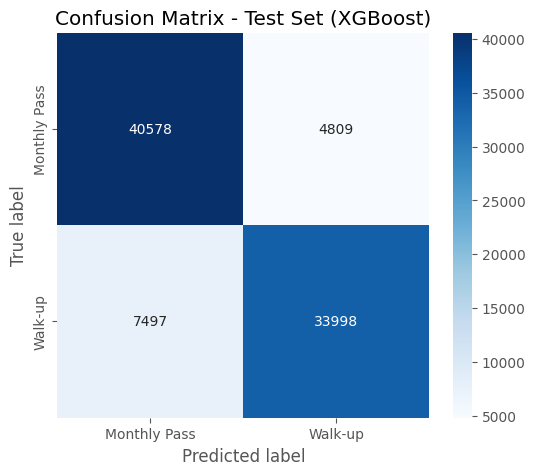

In [854]:
import seaborn as sns
cm_test = confusion_matrix(y_test_enc, xgb_optimized.predict(X_test_scaled))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Monthly Pass", "Walk-up"], yticklabels=["Monthly Pass", "Walk-up"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Test Set (XGBoost)")
plt.show()

## Deep Learning

In [824]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid')  # Output for binary classification
])

# Compile model with a slightly lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


/Users/oliverbohler/anaconda3/envs/clean_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,673 (49.50 KB)

 Trainable params: 12,225 (47.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [826]:
history = model.fit(
    X_train_scaled, y_train_enc, 
    epochs=50,  
    batch_size=32,  
    validation_data=(X_val_scaled, y_val_enc),  
    verbose=1  
)

Epoch 1/50
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.7201 - loss: 0.5670 - val_accuracy: 0.7624 - val_loss: 0.5075
Epoch 2/50
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7563 - loss: 0.5189 - val_accuracy: 0.7680 - val_loss: 0.5002
Epoch 3/50
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7618 - loss: 0.5101 - val_accuracy: 0.7752 - val_loss: 0.4901
Epoch 4/50
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.7659 - loss: 0.5020 - val_accuracy: 0.7782 - val_loss: 0.4837
Epoch 5/50
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7678 - loss: 0.4994 - val_accuracy: 0.7781 - val_loss: 0.4830
Epoch 6/50
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7713 - loss: 0.4972 - val_accuracy: 0.7787 - val_loss: 0.4810
Epoch 7/50
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7703 - loss: 0.4948 - val_accuracy: 0.7810 - val_loss: 0.4779
Epoch 8/50
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7713 - loss: 0

In [832]:
val_loss, val_acc = model.evaluate(X_val_scaled, y_val_enc)
print(f"Validation Accuracy: {val_acc:.4f}")

y_val_pred_probs = model.predict(X_val_scaled)
y_val_pred = (y_val_pred_probs > 0.5).astype(int) 

from sklearn.metrics import classification_report
print("FNN Validation Accuracy:", accuracy_score(y_val_enc, y_val_pred_enc))
print("\nClassification Report:\n", classification_report(y_val_enc, y_val_pred))

2716/2716 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - accuracy: 0.7877 - loss: 0.4630
Validation Accuracy: 0.7865
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 2s 552us/step
FNN Validation Accuracy: 0.7988651274141939

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.80     45444
           1       0.80      0.74      0.77     41438

    accuracy                           0.79     86882
   macro avg       0.79      0.78      0.79     86882
weighted avg       0.79      0.79      0.79     86882

